In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.stats import skew, norm, probplot, boxcox, f_oneway

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("diabetes_clean.csv")


In [5]:
# Fix data types
# df['Pregnancies'] = df['colname'].astype('category')
# df['colname'] = df['colname'].astype('float')
# df['colname'] = df['colname'].astype('int')

df['Outcome'] = df['Outcome'].astype('category')

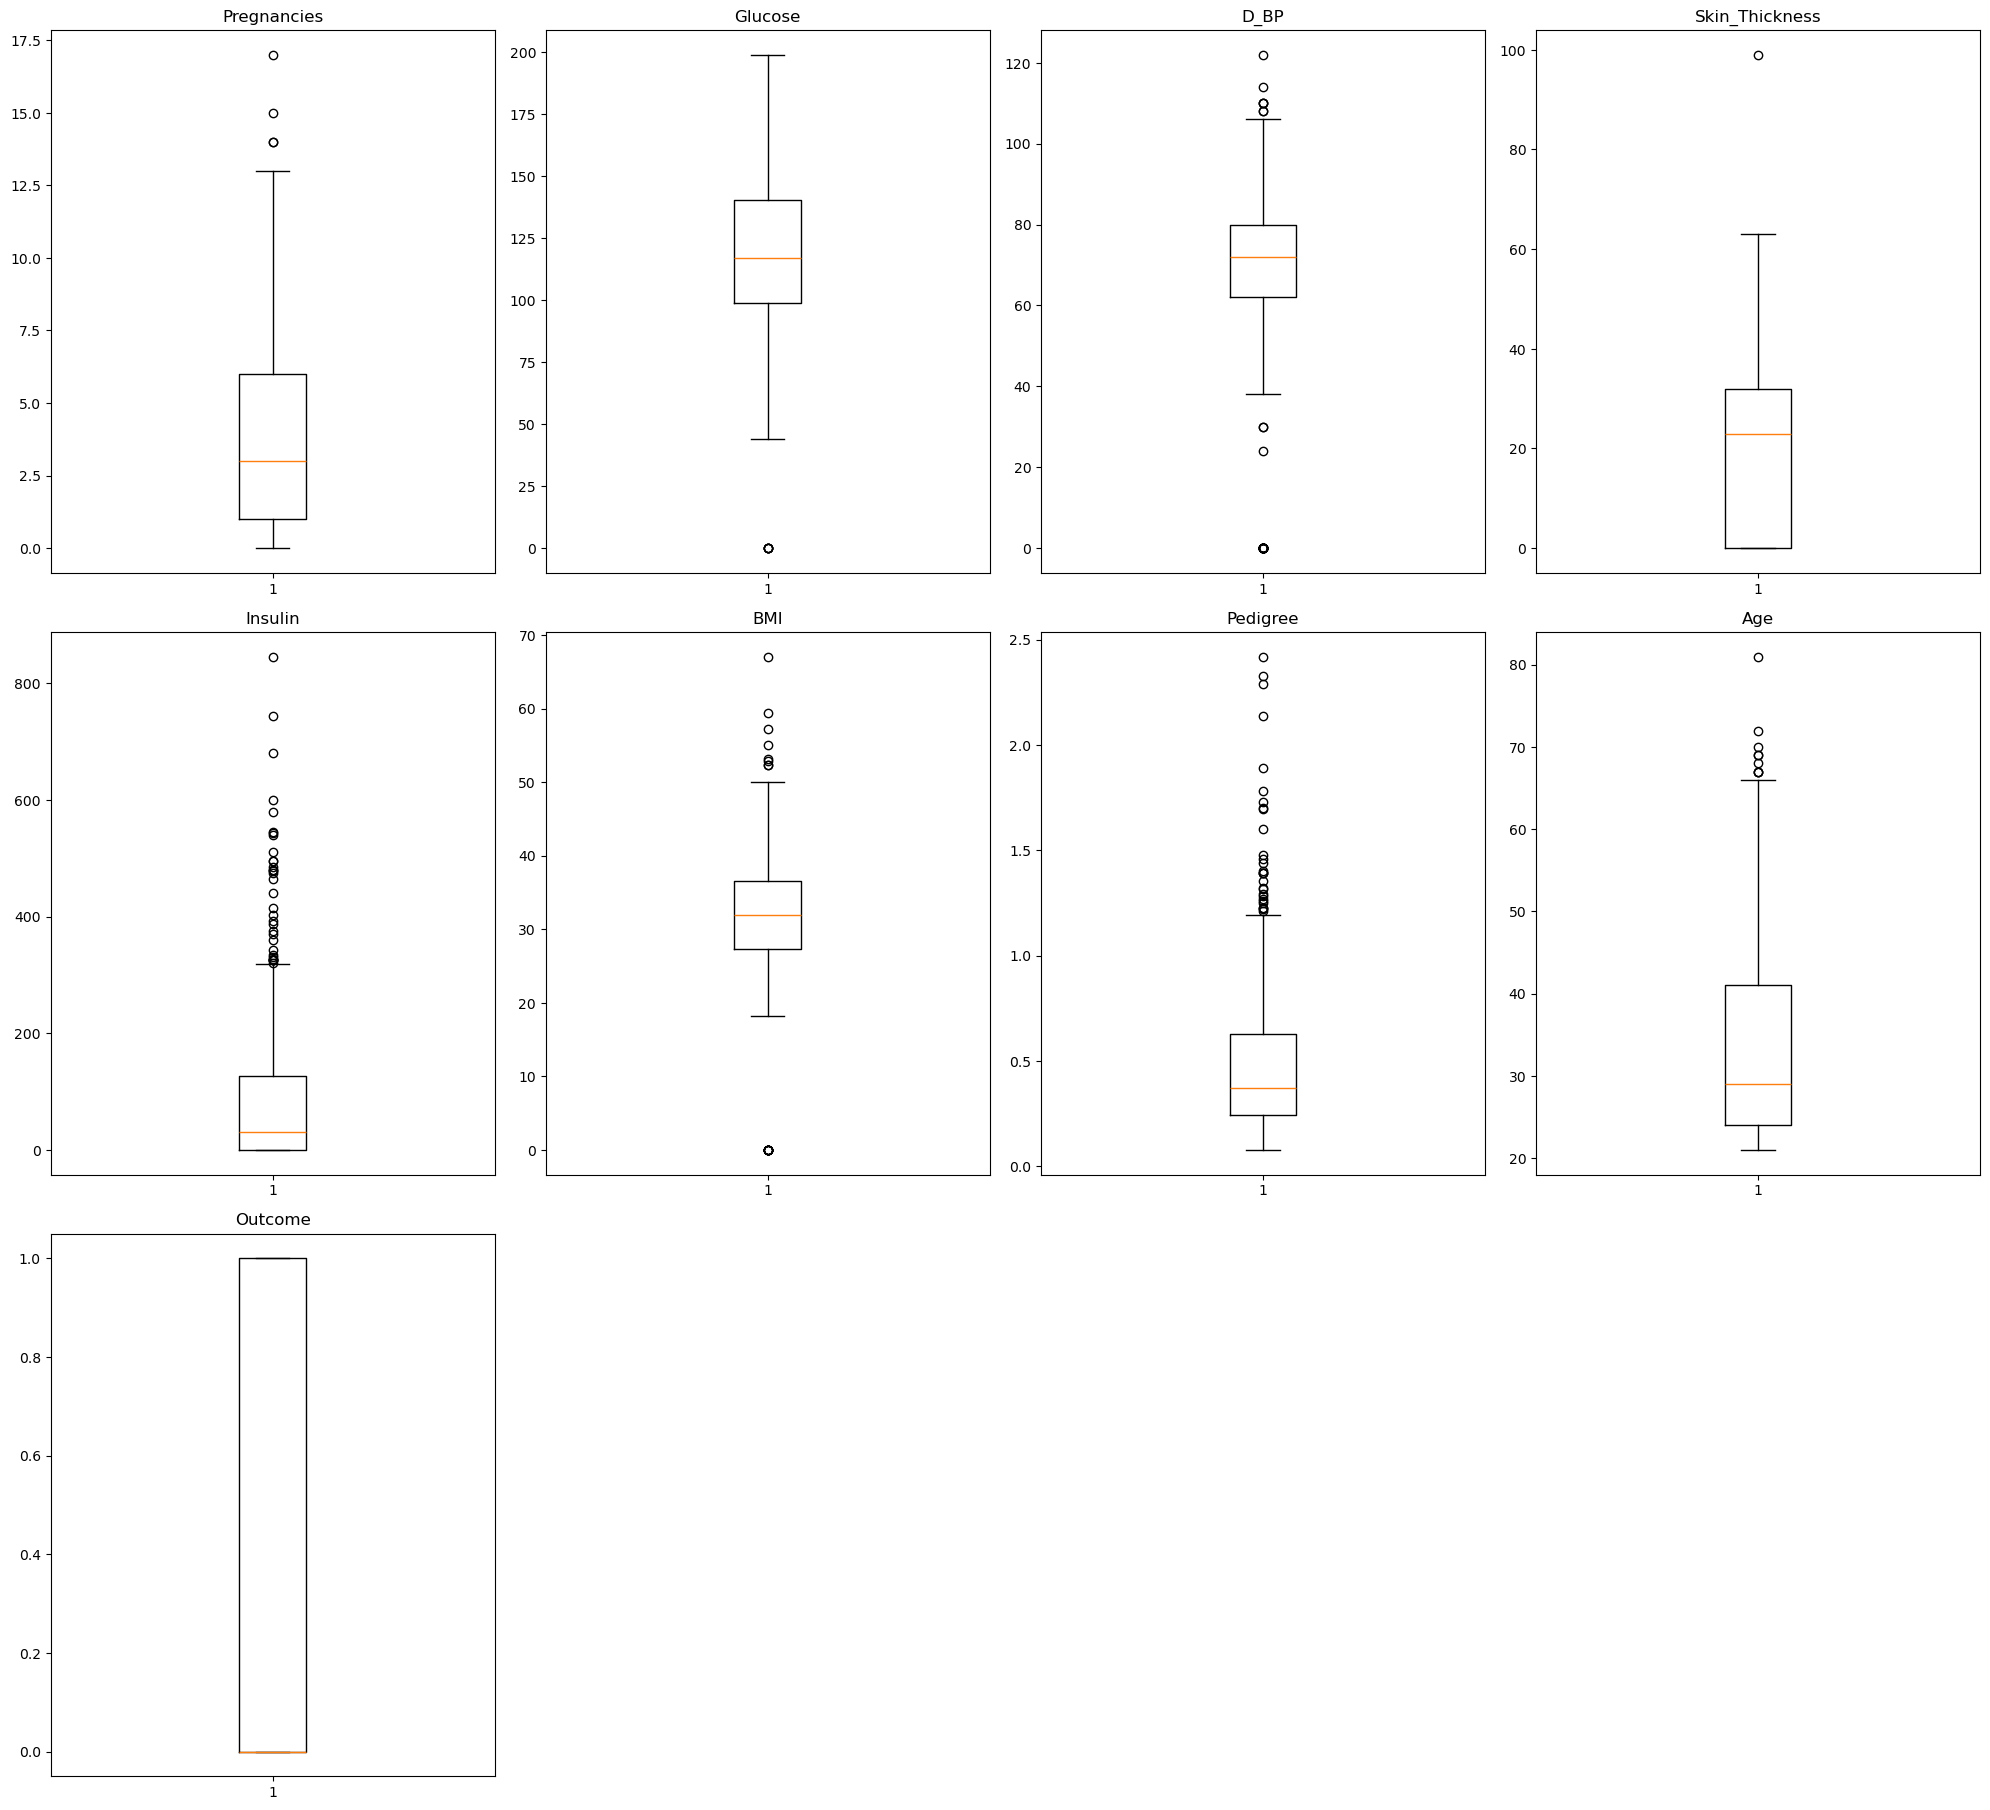

In [7]:
## RECALL...
# Outlier detection using boxplots

plt.figure(figsize=(20,30))

for i, variable in enumerate(df):
                     plt.subplot(5,4,i+1)
                     plt.boxplot(df[variable],whis=1.5)
                     plt.tight_layout()
                     plt.title(variable)
                    
plt.show()

In [9]:
# Use flooring and capping method
def treat_outliers(df,col):
    Q1=df[col].quantile(0.25) 
    Q3=df[col].quantile(0.75) 
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR 
    Upper_Whisker = Q3 + 1.5*IQR
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)                                                            
    return df

def treat_outliers_all(df, col_list):
    for c in col_list:
        df = treat_outliers(df,c)
    return df

In [11]:
numerical_col = df.select_dtypes(include=np.number).columns.tolist()
df = treat_outliers_all(df,numerical_col)


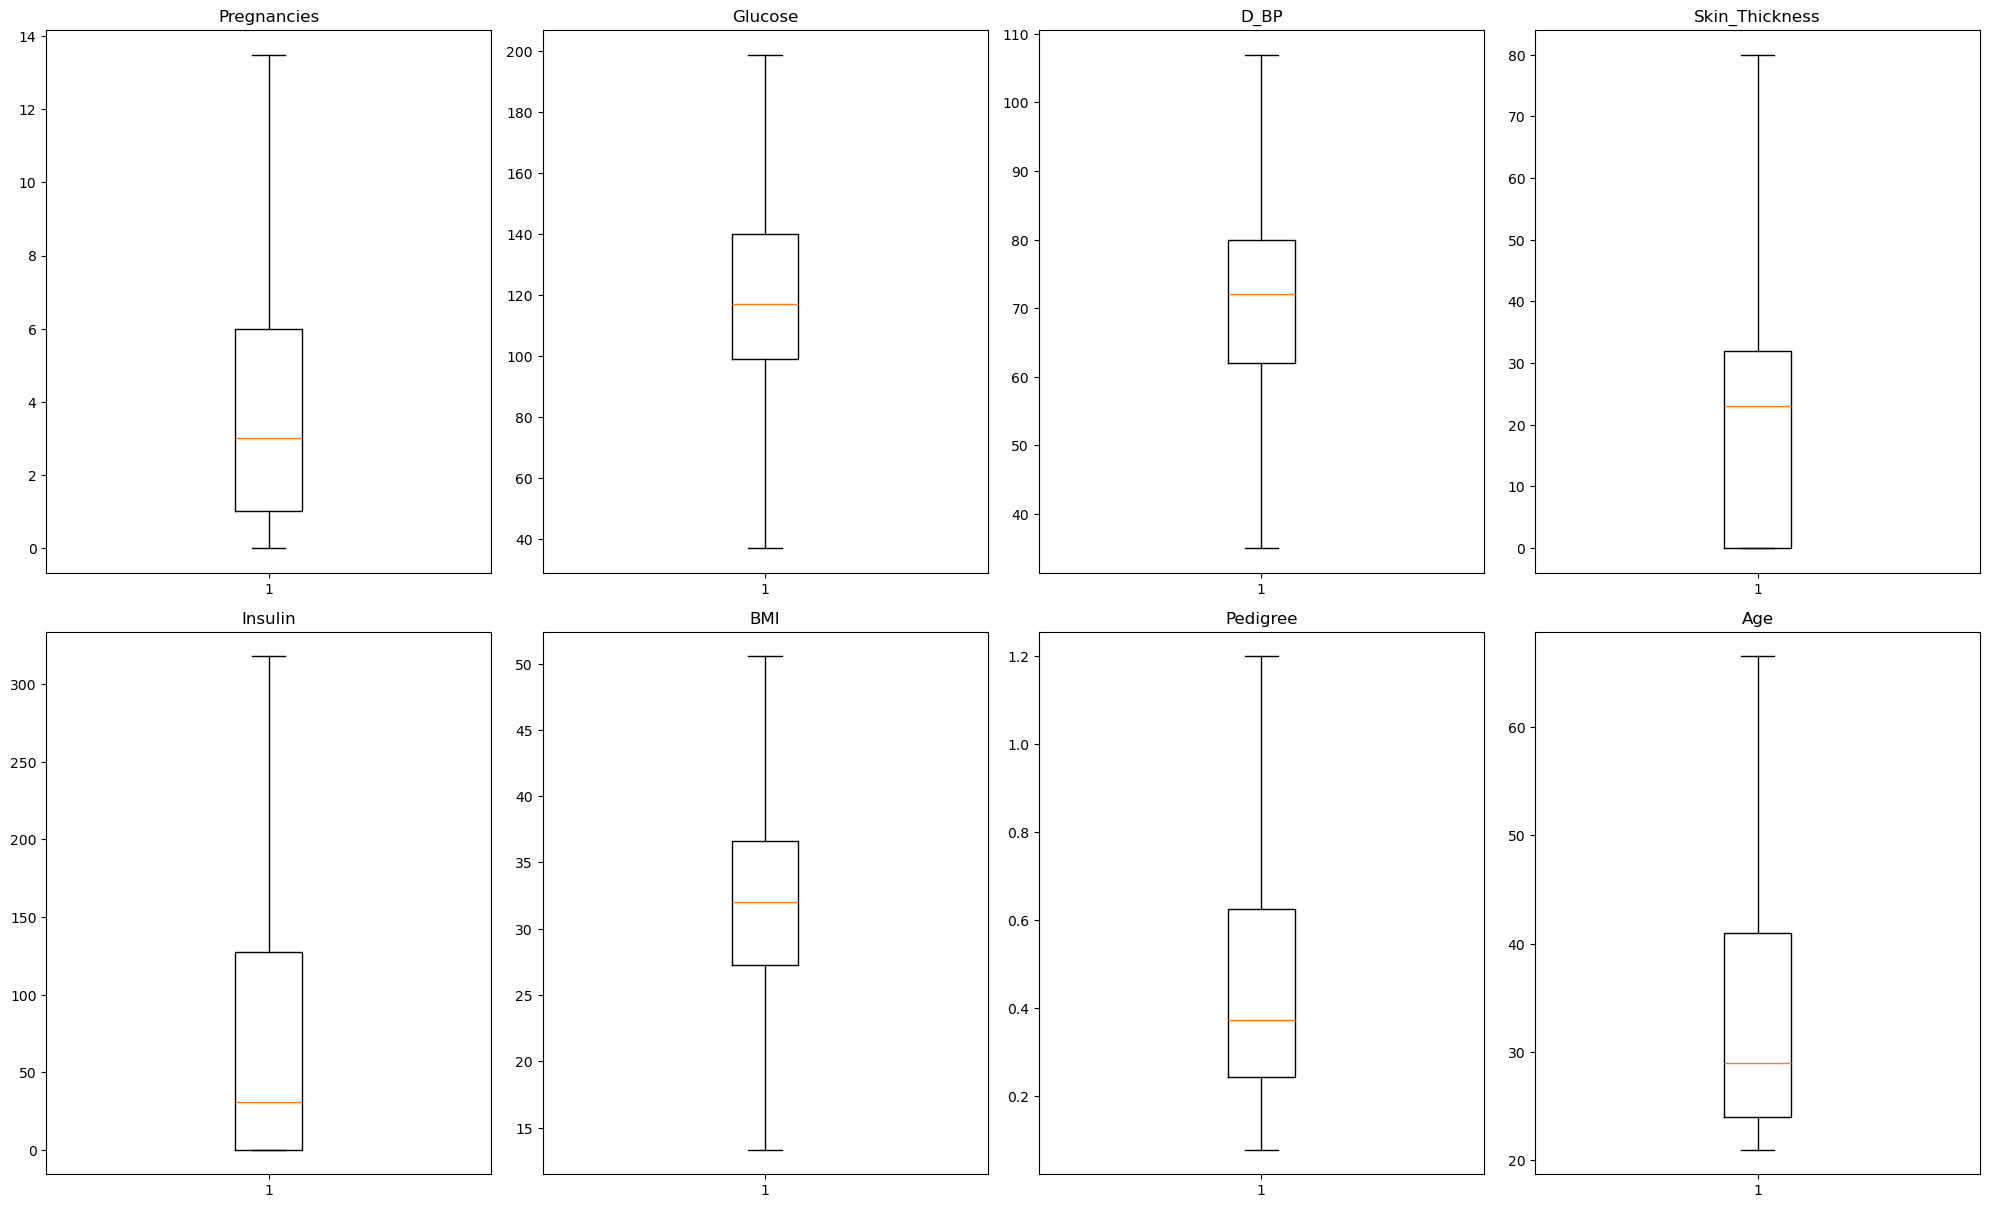

In [13]:
plt.figure(figsize=(20,30))

for i, variable in enumerate(numerical_col):
                     plt.subplot(5,4,i+1)
                     plt.boxplot(df[variable],whis=1.5)
                     plt.tight_layout()
                     plt.title(variable)

plt.show()

# Supervised Machine Learning (Classification)


In [17]:
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import stats, norm, skew
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model
from sklearn import metrics
from sklearn import datasets

In [19]:
# Make copy of data
data=df.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Pregnancies     768 non-null    float64 
 1   Glucose         768 non-null    float64 
 2   D_BP            768 non-null    int64   
 3   Skin_Thickness  768 non-null    int64   
 4   Insulin         768 non-null    float64 
 5   BMI             768 non-null    float64 
 6   Pedigree        768 non-null    float64 
 7   Age             768 non-null    float64 
 8   Outcome         768 non-null    category
dtypes: category(1), float64(6), int64(2)
memory usage: 49.0 KB


In [21]:
X = data.drop('Outcome',axis=1)    # Features
y = data['Outcome'].astype('int64') # Labels (Target or Outcome Variable)
# converting target to integers - since some functions might not work with bool type

In [23]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape)

(537, 8) (231, 8)


In [25]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='gini',class_weight={0:0.15,1:0.85},random_state=1)

# 2 commonly used splitting criteria are Gini impurity and information gain (entropy)
# Gini: measures the probability of misclassifying a randomly chosen element if it were randomly labeled
    # Would goal be to minimize or maximize the Gini impurity when making splits???
        # MINIMIZE
    
    
# Information Gain (Entropy): entropy measures impurity or uncertainty, while information gain quantifies reduction in entropy
    # Which do we want to minimize? Maximize?
        # MINIMIZE Entropy
        # MAXIMIZE Information Gain

In [31]:
model.fit(X_train, y_train)


DecisionTreeClassifier(class_weight={0: 0.15, 1: 0.85}, random_state=1)

In [29]:
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

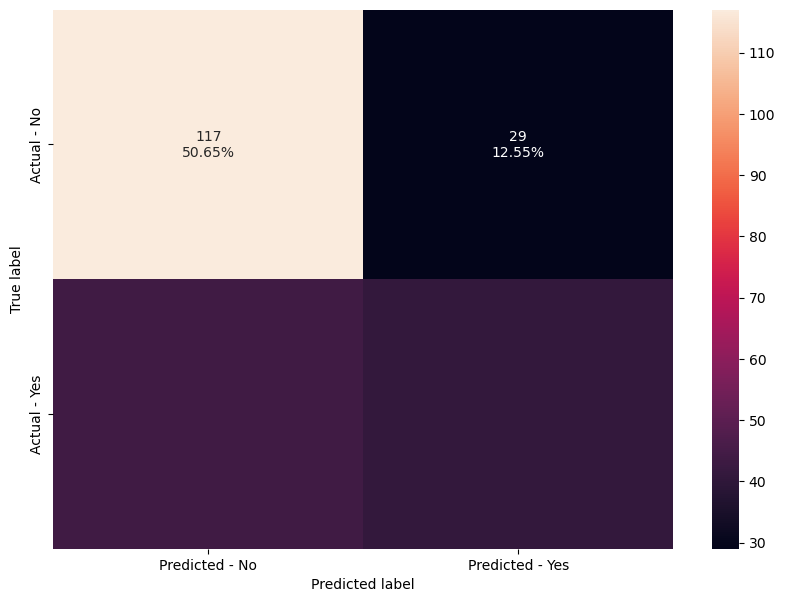

In [33]:
make_confusion_matrix(model,y_test)


In [35]:
y_train.value_counts(1)


Outcome
0    0.659218
1    0.340782
Name: proportion, dtype: float64

In [37]:
##  Function to calculate recall score
def get_recall_score(model):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
    print("Recall on test set : ",metrics.recall_score(y_test,pred_test))

In [39]:
get_recall_score(model)


Recall on training set :  1.0
Recall on test set :  0.4823529411764706


In [41]:
column_names = list(data.columns)
column_names.remove('Outcome')  # As this is the DV                
feature_names = column_names
print(feature_names)

['Pregnancies', 'Glucose', 'D_BP', 'Skin_Thickness', 'Insulin', 'BMI', 'Pedigree', 'Age']


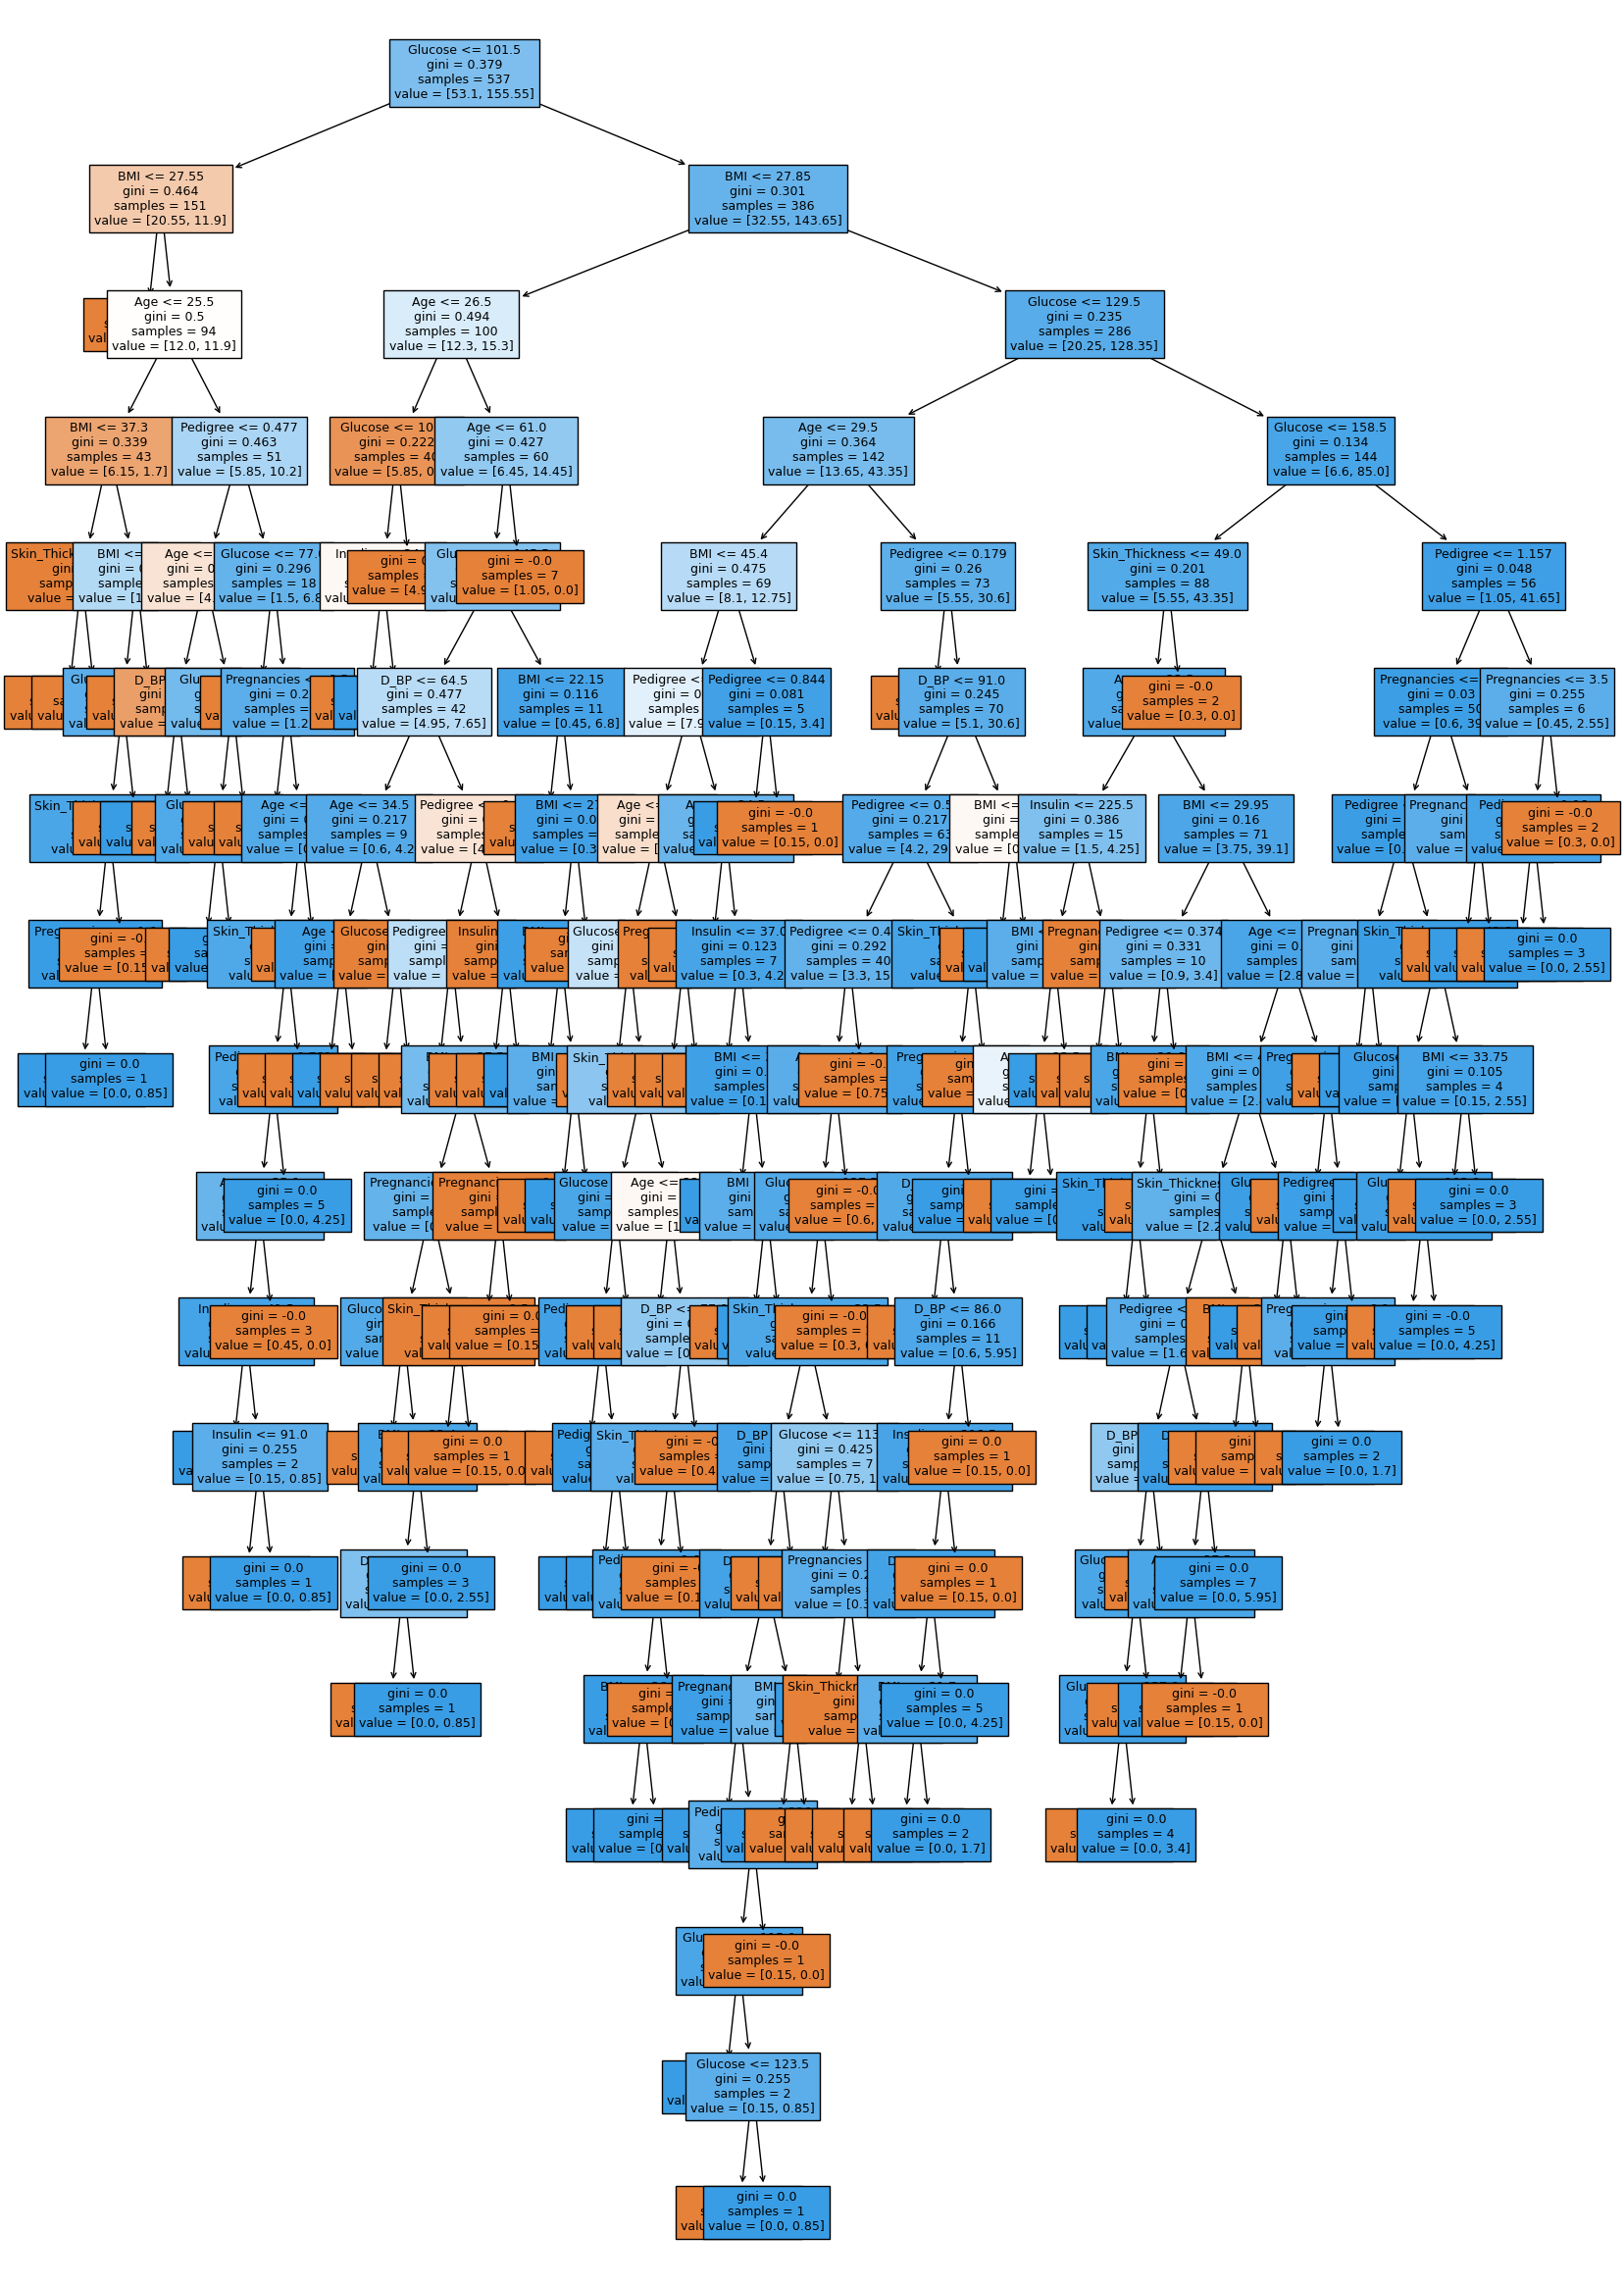

In [43]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

plt.figure(figsize=(20,30))
out = tree.plot_tree(model,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=None,)
# Code below will add arrows to the decision tree split if they are missing
for o in out:
     arrow = o.arrow_patch
     if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [44]:
# Text report showing the rules of the decision tree

print(tree.export_text(model,feature_names=feature_names,show_weights=True))

|--- Glucose <= 101.50
|   |--- BMI <= 27.55
|   |   |--- weights: [8.55, 0.00] class: 0
|   |--- BMI >  27.55
|   |   |--- Age <= 25.50
|   |   |   |--- BMI <= 37.30
|   |   |   |   |--- Skin_Thickness <= 5.00
|   |   |   |   |   |--- weights: [0.45, 0.00] class: 0
|   |   |   |   |--- Skin_Thickness >  5.00
|   |   |   |   |   |--- weights: [4.65, 0.00] class: 0
|   |   |   |--- BMI >  37.30
|   |   |   |   |--- BMI <= 38.30
|   |   |   |   |   |--- Glucose <= 97.50
|   |   |   |   |   |   |--- Skin_Thickness <= 33.00
|   |   |   |   |   |   |   |--- Pregnancies <= 1.00
|   |   |   |   |   |   |   |   |--- weights: [0.00, 0.85] class: 1
|   |   |   |   |   |   |   |--- Pregnancies >  1.00
|   |   |   |   |   |   |   |   |--- weights: [0.00, 0.85] class: 1
|   |   |   |   |   |   |--- Skin_Thickness >  33.00
|   |   |   |   |   |   |   |--- weights: [0.15, 0.00] class: 0
|   |   |   |   |   |--- Glucose >  97.50
|   |   |   |   |   |   |--- weights: [0.15, 0.00] class: 0
|   |   |   |

In [49]:
# Importance of features in the tree building (The importance of a feature is computed as the 
# (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance)

print (pd.DataFrame(model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                     Imp
Glucose         0.264872
Age             0.211394
BMI             0.204443
Pedigree        0.119376
D_BP            0.082055
Pregnancies     0.042798
Skin_Thickness  0.041764
Insulin         0.033297


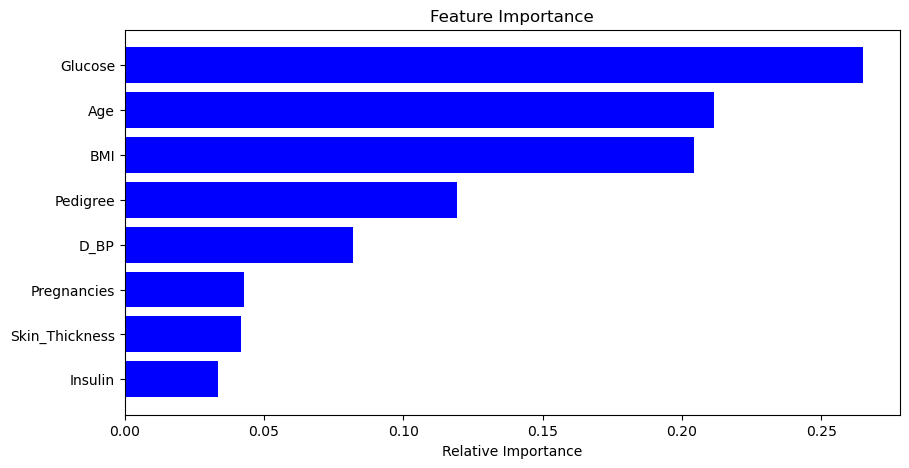

In [51]:
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,5))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [53]:
from sklearn.model_selection import GridSearchCV


In [55]:
# Choose the type of classifier
estimator = DecisionTreeClassifier(random_state=1,class_weight = {0:.15,1:.85})

# Grid of parameters to choose from
parameters = {
            'max_depth': np.arange(15,27),
            'criterion': ['entropy','gini'],
            'splitter': ['best','random'],
            'min_impurity_decrease': [0.0001,0.001,0.001],
            'max_features': ['log2','sqrt']
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.15, 1: 0.85}, max_depth=16,
                       max_features='log2', min_impurity_decrease=0.001,
                       random_state=1, splitter='random')

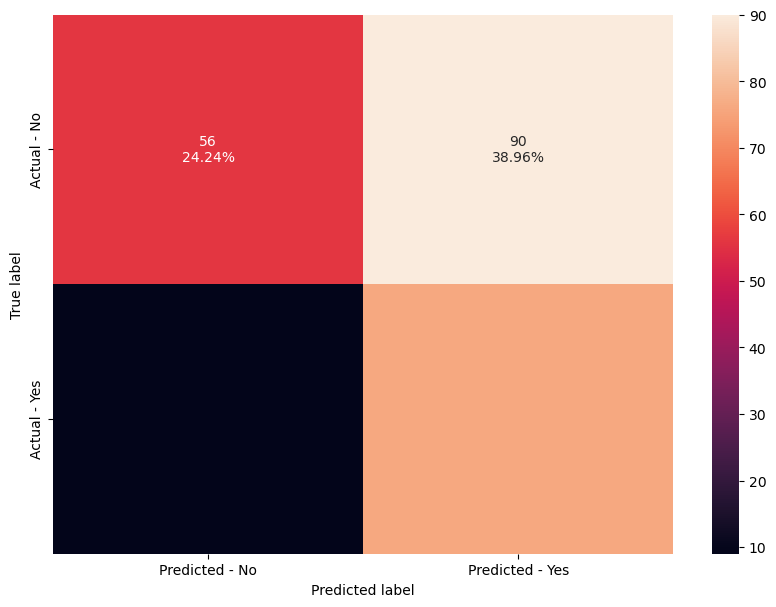

In [56]:
make_confusion_matrix(estimator,y_test)


In [57]:
get_recall_score(estimator)


Recall on training set :  0.9672131147540983
Recall on test set :  0.8941176470588236


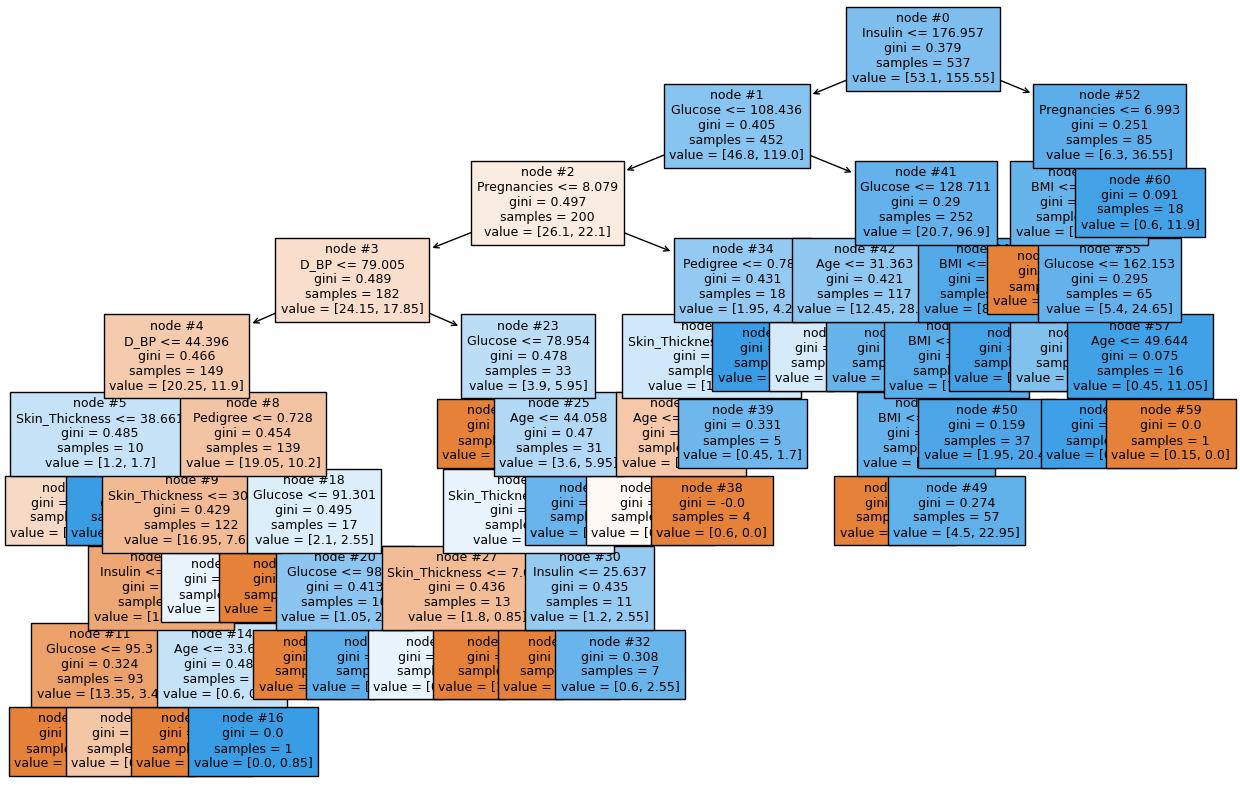

In [61]:
plt.figure(figsize=(15,10))
out = tree.plot_tree(estimator,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=None)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()


In [63]:
print(tree.export_text(estimator,feature_names=feature_names,show_weights=False))


|--- Insulin <= 176.96
|   |--- Glucose <= 108.44
|   |   |--- Pregnancies <= 8.08
|   |   |   |--- D_BP <= 79.00
|   |   |   |   |--- D_BP <= 44.40
|   |   |   |   |   |--- Skin_Thickness <= 38.66
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Skin_Thickness >  38.66
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- D_BP >  44.40
|   |   |   |   |   |--- Pedigree <= 0.73
|   |   |   |   |   |   |--- Skin_Thickness <= 30.97
|   |   |   |   |   |   |   |--- Insulin <= 126.44
|   |   |   |   |   |   |   |   |--- Glucose <= 95.30
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- Glucose >  95.30
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Insulin >  126.44
|   |   |   |   |   |   |   |   |--- Age <= 33.60
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- Age >  33.60
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Skin_Thi

In [65]:
# Gini importance
print (pd.DataFrame(estimator.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                     Imp
Glucose         0.541786
Age             0.104786
Skin_Thickness  0.089496
Insulin         0.084880
BMI             0.064324
D_BP            0.041469
Pregnancies     0.039861
Pedigree        0.033397


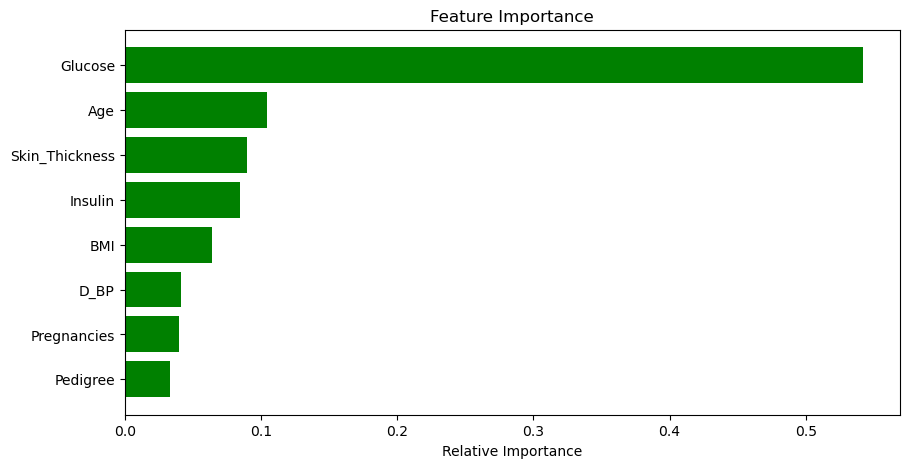

In [67]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,5))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [69]:
comparison_frame_dtree = pd.DataFrame({'Model':['Initial decision tree model','Decision tree with Grid SearchCV'], 'Train_Recall':[1,0.97], 'Test_Recall':[0.43, 0.89]}) 
comparison_frame_dtree

,Model,Train_Recall,Test_Recall
0,Initial decision tree model,1.00,0.43
1,Decision tree with Grid SearchCV,0.97,0.89


In [71]:
# Libraries for different classifiers
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# Libraries for model tuning and evaluation metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

In [73]:
data_2=df


In [75]:
X = data_2.drop('Outcome',axis=1)
y = data_2['Outcome'] 

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
# random state controls shuffling before applying split; shuffling is default; stratify allows shuffle by class
print(X_train.shape, X_test.shape)

(537, 8) (231, 8)


In [79]:
dtree_estimator = DecisionTreeClassifier(class_weight={0:0.35,1:0.65},random_state=1)

# Parameters:
parameters = {'max_depth': np.arange(2,10), 
              'min_samples_leaf': [5, 7, 10, 15],
              'max_leaf_nodes' : [2, 3, 5, 10,15],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Scoring method used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set to the optimal combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm
dtree_estimator.fit(X_train, y_train)


DecisionTreeClassifier(class_weight={0: 0.35, 1: 0.65}, max_depth=4,
                       max_leaf_nodes=5, min_impurity_decrease=0.0001,
                       min_samples_leaf=5, random_state=1)

In [80]:
##  Function to calculate different metric scores of the model - Accuracy, Recall, Precision AND F1
def get_metrics_score(model,flag=True):
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    # Recall = minimizes false negatives
    
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    # Precision = minimizes false positives
    
    train_f1 = f1_score(y_train,pred_train)
    test_f1 = f1_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1, test_f1))
        
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
        print("F1-Score on training set : ",metrics.f1_score(y_train,pred_train))
        print("F1-Score on test set : ",metrics.f1_score(y_test,pred_test))
    
    return score_list # returns the list with train and test scores

In [83]:
# Function to make confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy on training set :  1.0
Accuracy on test set :  0.7532467532467533
Recall on training set :  1.0
Recall on test set :  0.5679012345679012
Precision on training set :  1.0
Precision on test set :  0.6764705882352942
F1-Score on training set :  1.0
F1-Score on test set :  0.6174496644295301


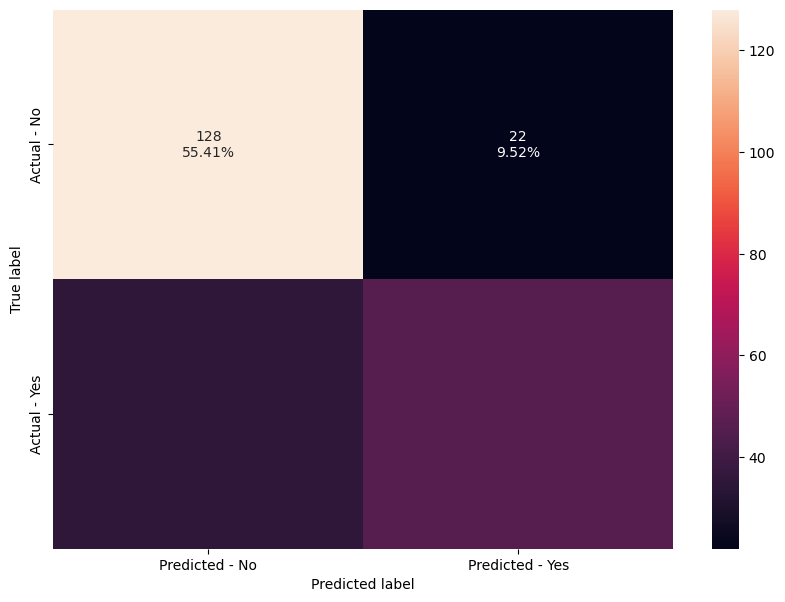

In [85]:
# Fit the model
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train,y_train)

# Calculate metrics
get_metrics_score(d_tree)

# Create the confusion matrix
make_confusion_matrix(d_tree,y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.7229437229437229
Recall on training set :  1.0
Recall on test set :  0.49382716049382713
Precision on training set :  1.0
Precision on test set :  0.6349206349206349
F1-Score on training set :  1.0
F1-Score on test set :  0.5555555555555555


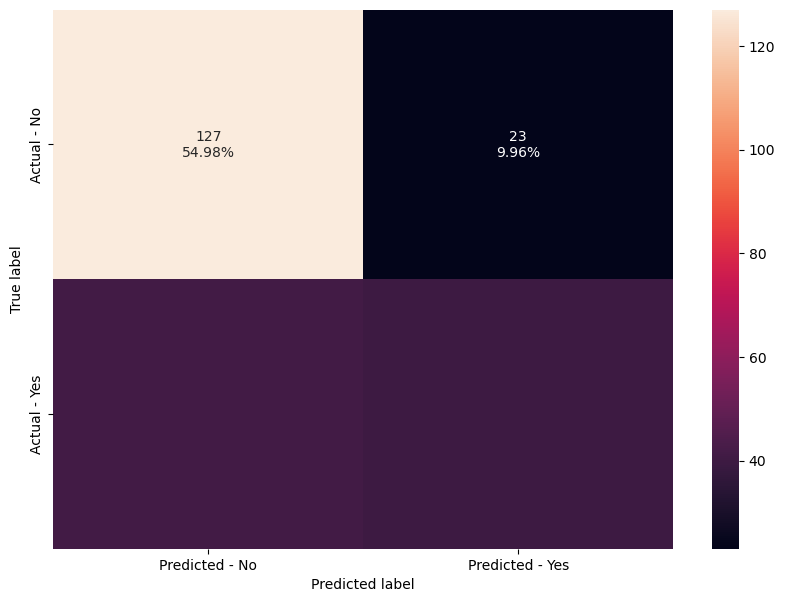

In [87]:
# Fit the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

# Calculate metrics
get_metrics_score(rf_estimator)

# Create the confusion matrix
make_confusion_matrix(rf_estimator,y_test)

Accuracy on training set :  0.994413407821229
Accuracy on test set :  0.7402597402597403
Recall on training set :  0.983957219251337
Recall on test set :  0.5185185185185185
Precision on training set :  1.0
Precision on test set :  0.6666666666666666
F1-Score on training set :  0.9919137466307278
F1-Score on test set :  0.5833333333333334


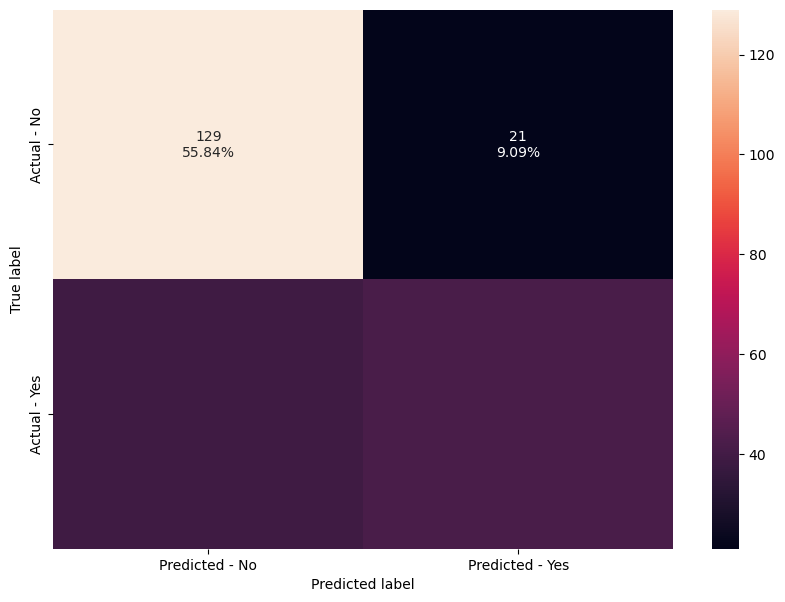

In [89]:
# Fit the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

# Calculate metrics
get_metrics_score(bagging_classifier)

# Create the confusion matrix
make_confusion_matrix(bagging_classifier,y_test)

In [91]:
%%time
dtree_tuned = DecisionTreeClassifier(class_weight={0:0.35,1:0.65},random_state=1)

parameters = {'max_depth': np.arange(2,10), 
              'min_samples_leaf': [5, 7, 10, 15],
              'max_leaf_nodes' : [2, 3, 5, 10,15],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

scorer = metrics.make_scorer(metrics.recall_score)

grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

dtree_tuned = grid_obj.best_estimator_

dtree_tuned.fit(X_train, y_train)

CPU times: total: 1.22 s
Wall time: 4.73 s


DecisionTreeClassifier(class_weight={0: 0.35, 1: 0.65}, max_depth=4,
                       max_leaf_nodes=5, min_impurity_decrease=0.0001,
                       min_samples_leaf=5, random_state=1)

Accuracy on training set :  0.7560521415270018
Accuracy on test set :  0.696969696969697
Recall on training set :  0.8288770053475936
Recall on test set :  0.7530864197530864
Precision on training set :  0.610236220472441
Precision on test set :  0.5495495495495496
F1-Score on training set :  0.7029478458049887
F1-Score on test set :  0.6354166666666667


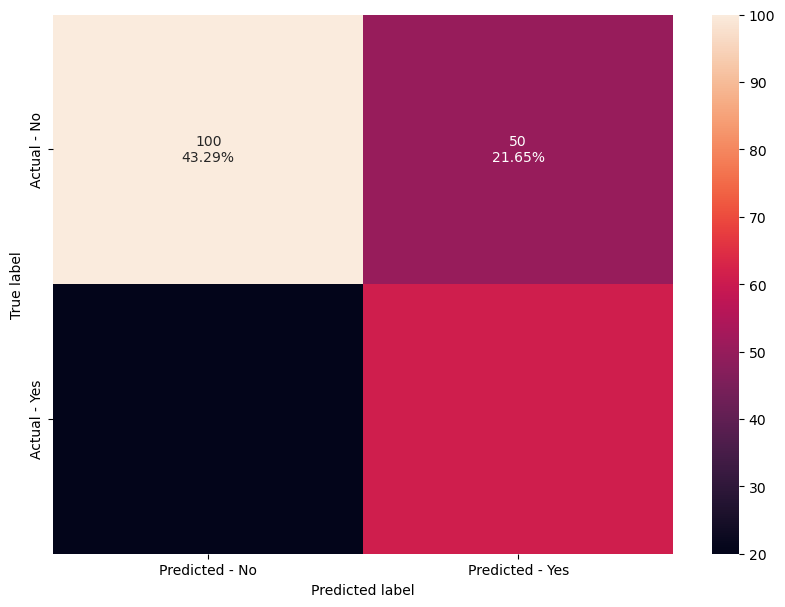

In [93]:
get_metrics_score(dtree_tuned)

make_confusion_matrix(dtree_tuned,y_test)

In [95]:
%%time 
# captures time it takes to run this block of code

# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(class_weight={0:0.35,1:0.65},random_state=1)

parameters = {  
                'max_depth': list(np.arange(3,10,1)),
                'max_features': np.arange(0.6,1.1,0.1),
                'max_samples': np.arange(0.7,1.1,0.1),
                'min_samples_split': np.arange(2, 20, 5),
                'n_estimators': np.arange(30,160,20),
                'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer,cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)

CPU times: total: 2min 17s
Wall time: 44min


RandomForestClassifier(class_weight={0: 0.35, 1: 0.65}, max_depth=6,
                       max_features=0.6, max_samples=0.9999999999999999,
                       min_impurity_decrease=0.01, min_samples_split=7,
                       n_estimators=30, random_state=1)

Accuracy on training set :  0.8379888268156425
Accuracy on test set :  0.7532467532467533
Recall on training set :  0.8609625668449198
Recall on test set :  0.7037037037037037
Precision on training set :  0.7252252252252253
Precision on test set :  0.6333333333333333
F1-Score on training set :  0.7872860635696821
F1-Score on test set :  0.6666666666666667


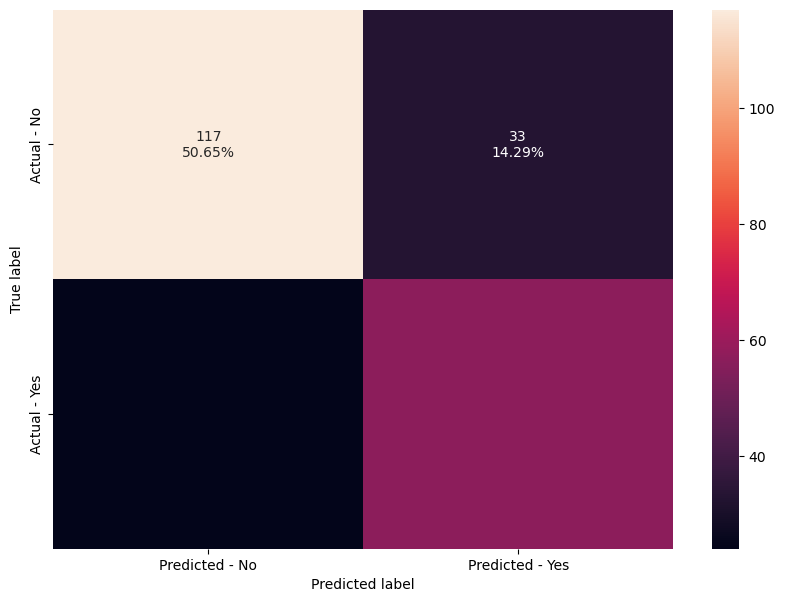

In [96]:
#Calculating different metrics
get_metrics_score(rf_tuned)

#Creating confusion matrix
make_confusion_matrix(rf_tuned,y_test)

In [97]:
%%time
bagging_tuned = BaggingClassifier(random_state=1)

parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

acc_scorer = metrics.make_scorer(metrics.recall_score)

grid_obj = GridSearchCV(bagging_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

bagging_tuned = grid_obj.best_estimator_

bagging_tuned.fit(X_train, y_train)

CPU times: total: 15.8 s
Wall time: 19.6 s


BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=50,
                  random_state=1)

Accuracy on training set :  1.0
Accuracy on test set :  0.7359307359307359
Recall on training set :  1.0
Recall on test set :  0.5555555555555556
Precision on training set :  1.0
Precision on test set :  0.6428571428571429
F1-Score on training set :  1.0
F1-Score on test set :  0.5960264900662252


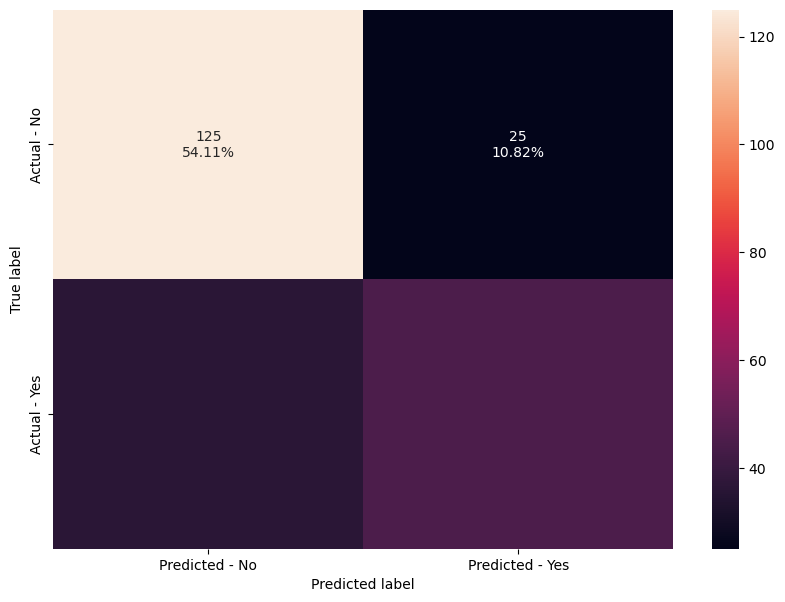

In [98]:
get_metrics_score(bagging_tuned)

make_confusion_matrix(bagging_tuned,y_test)

In [99]:
# Identify the models to compare
models = [d_tree, dtree_tuned, rf_estimator, bagging_classifier, bagging_tuned]

# Define empty lists to add results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []

# Loop through all identified models to get the metrics score (i.e., Accuracy, Recall, Precision, and F1)
for model in models:
    
    j = get_metrics_score(model,False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])

In [100]:
comparison_frame = pd.DataFrame({'Model':['Decision Tree','Tuned Decision Tree','Random Forest',
                                          'Bagging Classifier','Tuned Bagging Classifier'], 'Train_Accuracy': acc_train,
                                          'Test_Accuracy': acc_test, 'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test,
                                          'F1_Train':f1_train, 'F1_Test':f1_test})

#Sort models in decreasing order of test recall
comparison_frame.sort_values(by='F1_Test',ascending=False)

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,F1_Train,F1_Test
1,Tuned Decision Tree,0.756052,0.696970,0.828877,0.753086,0.610236,0.549550,0.702948,0.635417
0,Decision Tree,1.000000,0.753247,1.000000,0.567901,1.000000,0.676471,1.000000,0.617450
4,Tuned Bagging Classifier,1.000000,0.735931,1.000000,0.555556,1.000000,0.642857,1.000000,0.596026
3,Bagging Classifier,0.994413,0.740260,0.983957,0.518519,1.000000,0.666667,0.991914,0.583333
2,Random Forest,1.000000,0.722944,1.000000,0.493827,1.000000,0.634921,1.000000,0.555556


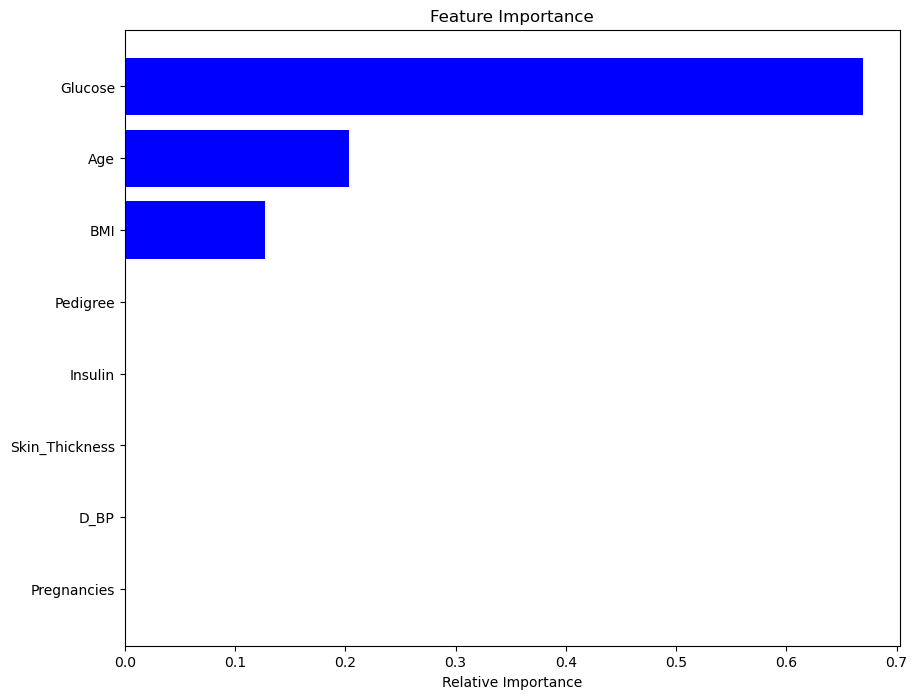

In [101]:
feature_names = X_train.columns
importances = dtree_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [111]:
print (pd.DataFrame(dtree_tuned.feature_importances_, columns = ["Relative Importance"], index = X_train.columns).sort_values(by = 'Relative Importance', ascending = False))


                Relative Importance
Glucose                    0.669350
Age                        0.203284
BMI                        0.127366
Pregnancies                0.000000
D_BP                       0.000000
Skin_Thickness             0.000000
Insulin                    0.000000
Pedigree                   0.000000
